<a href="https://colab.research.google.com/github/XSerejoX/public-codes/blob/main/Jogos_Fut.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Overview
Futebol. O esporte mais assistido e jogado no mundo.

Um dos grandes desafios da Ciência de dados é detectar padrões em múltiplas áreas de conhecimento, neste caso vou inferir com dados esportivos de futebol britânico, a famosa e prestigiada Premier League.

sem conhecimento profundo em futebol, vou criar um modelo que prevê vitorias, empates ou derrotas de resultados de jogos oficiais da Premier League, apenas utilizando técnicas de aprendizado de máquina.

Lendo e iniciando os arquivos

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
path = '/content/train_futebol.csv'
path2 = '/content/test_futebol.csv'
test_futebol = pd.read_csv(path2)
df = pd.read_csv(path)



Primeiramente, usei dois tipos de modelos: Redes neurais e gradient boosting. usei primeiro o gradient boosting pois ele não é um modelo tão complexo como redes neurais e nem tão simples como arvores de decisão. ele é muito usado para classificação e é versátil.

Para questões de iteração, decidi usar um modelo mais complexo, redes neurais, pois o primeiro desempenho estava ruim. redes neurais acabou sendo sensivel demais e muito complexo. portanto, decidi voltar para o bossting para dar tweaks e melhorar seu desempenho. Depois de aplicar mais engenharia de features no modelo ele pode performar melhor e tive mais segurança para continuar com o gradient boosting.

Feature Engineering

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from scipy.stats import randint
from datetime import datetime

#separando mintuos de jogo

df['PrimeiroTempo'] = ((df['minuto']<=45) & (df['minuto']>0)).astype(int)
df['SegundoTempo'] = ((df['minuto']>45) & (df['minuto']<=90)).astype(int)
df['Final_Critico'] = ((df['minuto']> 80) & (df['minuto']<=101)).astype(int)



test_futebol['PrimeiroTempo'] = ((test_futebol['minuto']<=45) & (test_futebol['minuto']>0)).astype(int)
test_futebol['SegundoTempo'] = ((test_futebol['minuto']>45) & (test_futebol['minuto']<=90)).astype(int)
test_futebol['Final_Critico'] = ((test_futebol['minuto']>80) & (test_futebol['minuto']<=101)).astype(int)


#convertendo data em date time

df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y')
test_futebol['Date'] = pd.to_datetime(test_futebol['Date'], format='%d.%m.%Y')

# Separando a data

df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

test_futebol['DayOfWeek'] = test_futebol['Date'].dt.dayofweek
test_futebol['Month'] = test_futebol['Date'].dt.month
test_futebol['Year'] = test_futebol['Date'].dt.year

#Calculando a diferença de tempo entre eventos dentro de cada jogo
df['time_diff'] = df.groupby('Date')['minuto'].diff().fillna(0).astype(int)
test_futebol['time_diff'] = test_futebol.groupby('Date')['minuto'].diff().fillna(0).astype(int)

def hora_para_inteiro(hora_str):
    hora, minuto = map(int, hora_str.split(':'))
    return hora  # Retorna apenas a parte da hora como inteiro

# Aplicando a função à coluna 'hora'
df['hora'] = df['Time'].apply(hora_para_inteiro)
test_futebol['hora'] = test_futebol['Time'].apply(hora_para_inteiro)







separação de variáveis

In [ ]:
# Definição das variáveis numéricas e categóricas

num_variables = ['Round', 'time_diff', 'Yellow_Away', 'Yellow_Home', 'Goal_Away', 'Goal_Home',
                 'Red_Card_Away', 'Red_Card_Home', 'Own_Home', 'Own_Away', 'Penalty_Missed_Home',
                 'Penalty_Missed_Away', 'Var_Home', 'Var_Away', 'minuto']

cat_variables = ['Home', 'Away', 'evento', 'DayOfWeek', 'Month','Year', 'PrimeiroTempo',
                 'SegundoTempo', 'Final_Critico']

1. Definindo X e y,

2. splitando o data set,

3. criando o preprocessador,

4. utilizando o gradient boost e aplicando o pipeline nele,

5. usando randomized search para melhores parametros,

6. e calculando resultados e avaliações com métricas


Trecho de código usado por mim

In [ ]:
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.impute import SimpleImputer
import joblib
import numpy as np

# Carregando o modelo treinado
pipeline = joblib.load('modelo_treinado.pkl')

# Criando o preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), num_variables),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_variables)
    ])

# Criando o DataFrame X
total_variables = num_variables + cat_variables
X = df[total_variables]
y = df['WIN']

# Dividindo em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Cálculo de pesos de amostras balanceados
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Definindo o espaço de busca para os hiperparâmetros
param_dist = {
    'classifier__n_estimators': [100, 150],
    'classifier__max_depth': [3, 4],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2],
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__subsample': [0.7, 0.8]

}

# Criando o classificador
classifier = GradientBoostingClassifier(random_state=42)

# Pipeline com o classificador
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])


Adicionalmente aplico um Random Search. o random search me deu os melhores parametros dentro de um escopo, e eu decidi usar esses parametros para assim treinar o modelo.

In [ ]:
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=19,  # Número de combinações a serem testadas
    cv=3,  # Validação cruzada
    scoring='accuracy',  # Métrica de avaliação
    n_jobs=-1,  # Usar todos os núcleos disponíveis
    random_state=42
)

# Treinando o modelo usando RandomizedSearchCV
random_search.fit(X_train, y_train, classifier__sample_weight=sample_weights)

# Melhor modelo encontrado
best_model = random_search.best_estimator_

# Fazendo previsões no conjunto de teste
y_pred = best_model.predict(X_test)

# Avaliando o modelo
print(f"Acurácia: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

# Avaliando o desempenho no conjunto de treinamento
y_train_pred = best_model.predict(X_train)
training_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Acurácia do treinamento: {training_accuracy:.2f}")

# Mostrando os melhores parâmetros encontrados
print("Melhores parâmetros encontrados:")
print(random_search.best_params_)

y_train_pred = best_model.predict(X_train)
training_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Acurácia do treinamento: {training_accuracy:.2f}")

Acurácia: 0.756178196545169
              precision    recall  f1-score   support

        Away       0.79      0.79      0.79      3643
        Draw       0.55      0.66      0.60      2788
        Home       0.87      0.78      0.82      5668

    accuracy                           0.76     12099
   macro avg       0.74      0.74      0.74     12099
weighted avg       0.77      0.76      0.76     12099

Acurácia do treinamento: 0.78
Melhores parâmetros encontrados:
{'classifier__subsample': 0.7, 'classifier__n_estimators': 150, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 2, 'classifier__max_depth': 4, 'classifier__learning_rate': 0.1}
Acurácia do treinamento: 0.78


Salvar o modelo

In [ ]:
import joblib

# Salvar o modelo
joblib.dump(best_model, 'best_model.pkl')

['best_model.pkl']

In [ ]:
total_variables = num_variables + cat_variables

X_test_final = test_futebol[total_variables]
pipeline2 = joblib.load('best_model.pkl')
# Preprocessar os dados de teste da mesma forma que os dados de treino
X_test_final = test_futebol[total_variables]

predictions = pipeline2.predict(X_test_final)

matriz de confusão:

o modelo está indo razoavelmente bem em saber a diferença correta das labels AWAY e HOME, e está tendo mais dificuldade em identificar DRAWS, confundindo ela com outras labels.


In [ ]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

[[2882  570  191]
 [ 465 1838  485]
 [ 324  915 4429]]


Curva ROC

a curva roc está tendo resultados aproximados de verdadeiros positivos, porém tendo a linha do DRAW um pouco mais afastada das demais, demonstrando um erro maior.


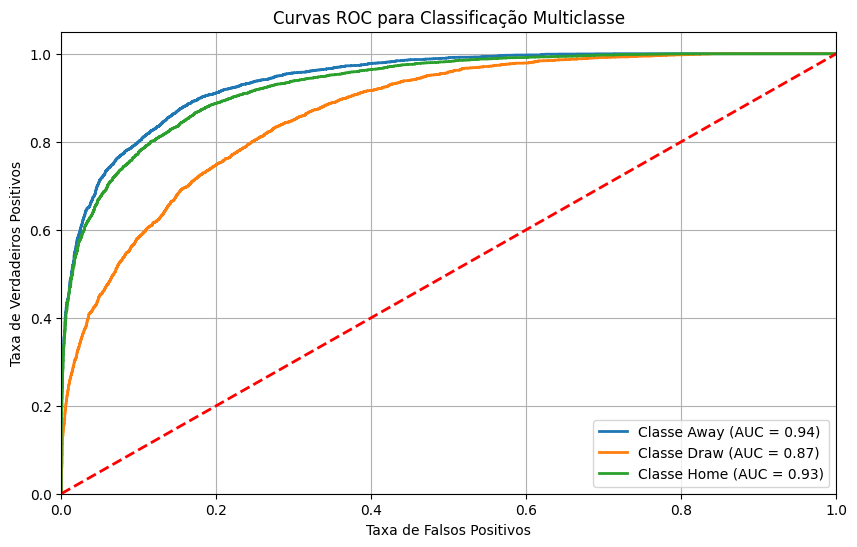

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

classes = np.unique(y_test)
n_classes = len(classes)

# Binarizar as classes para ROC
y_test_bin = label_binarize(y_test, classes=classes)
y_pred_proba = best_model.predict_proba(X_test)  # Obter probabilidades de previsão

# Inicializar variáveis para armazenar a AUC e a curva ROC
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calcular a curva ROC para cada classe
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotar as curvas ROC
plt.figure(figsize=(10, 6))

# Plotar cada curva ROC
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Classe {classes[i]} (AUC = {roc_auc[i]:.2f})')

# Plotar linha de referência
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')

# Configurações do gráfico
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curvas ROC para Classificação Multiclasse')
plt.legend(loc='lower right')
plt.grid()
plt.show()

Submetendo e treinando com dados novos de uma competição universitária do kaggle

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib
# Definindo variáveis numéricas e categóricas para teste
num_variables_test = [
    'Round', 'time_diff', 'Yellow_Away', 'Yellow_Home',
    'Goal_Away', 'Goal_Home', 'Red_Card_Away', 'Red_Card_Home',
    'Own_Home', 'Own_Away', 'Penalty_Missed_Home',
    'Penalty_Missed_Away', 'Var_Home', 'Var_Away', 'minuto']


cat_variables_test= ['Home', 'Away', 'evento', 'DayOfWeek', 'Month','Year', 'PrimeiroTempo',
                 'SegundoTempo', 'Final_Critico']

all_variables_test = num_variables_test + cat_variables_test

X_comp = test_futebol[all_variables_test]

# Carregando o modelo treinado
pipeline2 = joblib.load('best_model.pkl')

# Fazendo previsões nos dados de competição
y_pred_comp = pipeline2.predict(X_comp)

# Criar o DataFrame para submissão
submission = pd.DataFrame({
    'index': test_futebol.index,
    'WIN': y_pred_comp
})

# Salvar o arquivo .csv
submission.to_csv('submission_bm.csv', index=False)

print("Arquivo de submissão criado com sucesso!")



Arquivo de submissão criado com sucesso!


## Conclusão

O modelo teve um desenpenho bem aceitavel para classificações, e o desafio maior foi fazer com que ele previsse a label DRAW, que naturalmente é mais complexa. Adicionei mais features para captar mais nuancias nessa variável. O processo de pre-processamento foi menos desafiador, e mais desafiador, foi fazer com que o modelo se adequasse de maneira equivalente para todas as labels em relação a dados completamente novos. A acurancia teve seu devido valor, de 72 por cento, para  esses dados completamente novos, entretanto.